In [1]:
import os
import shutil

root_dir = "/kaggle/input/kvasir-v2-a-gastrointestinal-tract-dataset"
dest_directory = "/kaggle/working/dataset"
os.mkdir(dest_directory)

for directory in os.listdir(root_dir):
    dir_path = os.path.join(root_dir, directory)
    destination = os.path.join(dest_directory, directory)
    os.mkdir(destination)
    for directory2 in os.listdir(dir_path):
        dir_path2 = os.path.join(dir_path, directory2)
        for image in os.listdir(dir_path2):
            image_path = os.path.join(dir_path2, image)
            dest_path = os.path.join(destination, image)
            shutil.copy(image_path, dest_path)

### Listing Physical Devices for TensorFlow

In [2]:
import tensorflow as tf
tf.config.list_physical_devices(
    device_type=None
)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [24]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras import Sequential

from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Creating Training and Validation Datasets

In [5]:
dataset_path = "/kaggle/working/dataset"
image_size = 224, 224
batch_size = 128

train_ds = image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  label_mode="categorical",
  seed=23,
  image_size=image_size,
  batch_size=batch_size)


val_ds = image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  label_mode="categorical",
  seed=23,
  image_size=image_size,
  batch_size=batch_size)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Found 8000 files belonging to 8 classes.
Using 1600 files for validation.


In [6]:
class_names = train_ds.class_names

### Splitting Validation Dataset for Validation and Test

In [7]:
# Returns the cardinality of the data
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

### Prefetching Datasets for Improved Performance
In machine learning workflows, data pipeline efficiency significantly impacts training speed. The prefetch method in TensorFlow helps optimize this pipeline by preparing data ahead of its actual usage during model training.


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Constructing and Compiling a Transfer Learning Model

In [10]:
model = Sequential()
base_model = tf.keras.applications.MobileNetV3Large(
    include_top=False,
    weights="imagenet",
    input_shape = (224,224, 3))


for layer in base_model.layers:
        layer.trainable=True
model.add(base_model)
model.add(Flatten())
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=0.004, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
          loss=CategoricalCrossentropy(),
          metrics=['accuracy'])

12683000/12683000 [==============================] - 0s 0us/step


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 47040)             0         
                                                                 
 dense (Dense)               (None, 8)                 376328    
                                                                 
Total params: 3372680 (12.87 MB)
Trainable params: 3348280 (12.77 MB)
Non-trainable params: 24400 (95.31 KB)
_________________________________________________________________


Callbacks for Model Training

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-5)

best = ModelCheckpoint(filepath="training_weights/best/model_best_val_accuracy.ckpt",
                                         save_weights_only=True,
                                         mointor="val_accuracy",
                                         mode="max",
                                         save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss', patience=20)


### Training the model

In [13]:
model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[reduce_lr, best, early_stop])

Epoch 1/50
50/50 [==============================] - 76s 615ms/step - loss: 0.8330 - accuracy: 0.8005 - val_loss: 3.1586 - val_accuracy: 0.6394 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - 31s 553ms/step - loss: 0.0966 - accuracy: 0.9655 - val_loss: 3.1440 - val_accuracy: 0.7139 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - 32s 568ms/step - loss: 0.0249 - accuracy: 0.9917 - val_loss: 3.2890 - val_accuracy: 0.7067 - lr: 0.0010
Epoch 4/50
50/50 [==============================] - 32s 567ms/step - loss: 0.0106 - accuracy: 0.9962 - val_loss: 3.5595 - val_accuracy: 0.7079 - lr: 0.0010
Epoch 5/50
50/50 [==============================] - 31s 558ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 2.2157 - val_accuracy: 0.8029 - lr: 0.0010
Epoch 6/50
50/50 [==============================] - 31s 550ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 2.3707 - val_accuracy: 0.7933 - lr: 0.0010
Epoch 7/50
50/50 [==============================] - 31s 556ms/st

### Saving the model

In [14]:
model.save("final.h5")

### Plotting Training and Validation Metrics
This helps in identifying when the models starts to overfit to the training data

In [15]:
history = model.history

In [16]:
loss = history.history['loss'] + history.history['loss']
val_loss = history.history['val_loss'] + history.history['val_loss']
accuracy = history.history['accuracy'] + history.history['accuracy']
val_accuracy = history.history['val_accuracy'] + history.history['val_accuracy']

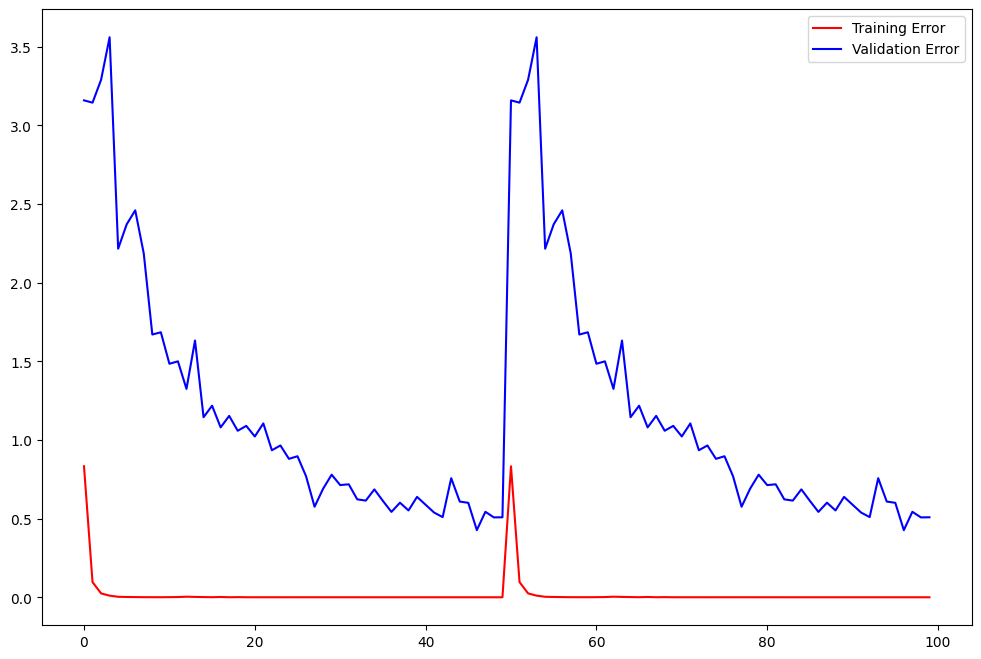

In [17]:
plt.figure(figsize=(12,8))
plt.plot(loss,color='r',label='Training Error')
plt.plot(val_loss, color='b',label='Validation Error')
plt.legend()
plt.show()

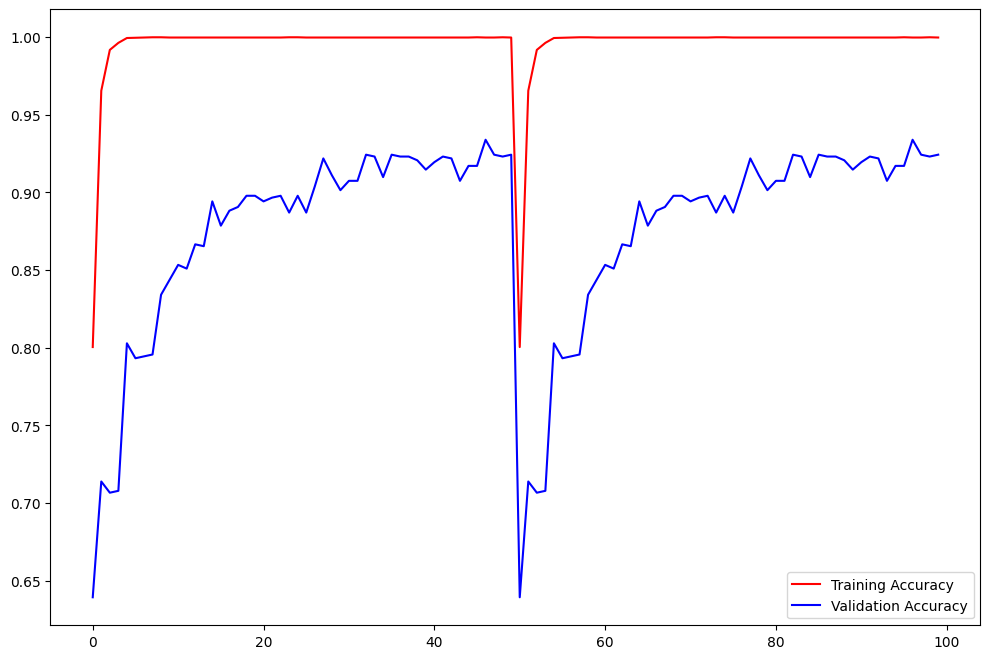

In [18]:
plt.figure(figsize=(12,8))
plt.plot(accuracy,color='r',label='Training Accuracy')
plt.plot(val_accuracy, color='b',label='Validation Accuracy')
plt.legend()
plt.show()

### Plotting the Confusion Matrix

In [19]:
true_labels = []
predicted_labels = []

# Iterate through test dataset to get true labels
for images, labels in test_ds:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Assuming one-hot encoded labels

    # Predict labels using the model
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Convert lists to NumPy arrays for easier processing
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

4/4 [==============================] - 0s 27ms/step


In [20]:
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.94


In [21]:
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 91   3   0   0   0   0   0   0]
 [ 10  82   0   0   0   0   0   0]
 [  0   0  65   0   0  17   0   0]
 [  0   0   0  99   0   0   0   0]
 [  0   0   0   0 111   0   0   0]
 [  0   0   8   0   1  84   0   0]
 [  0   0   0   1   1   0  97   0]
 [  0   0   0   1   0   0   2  95]]


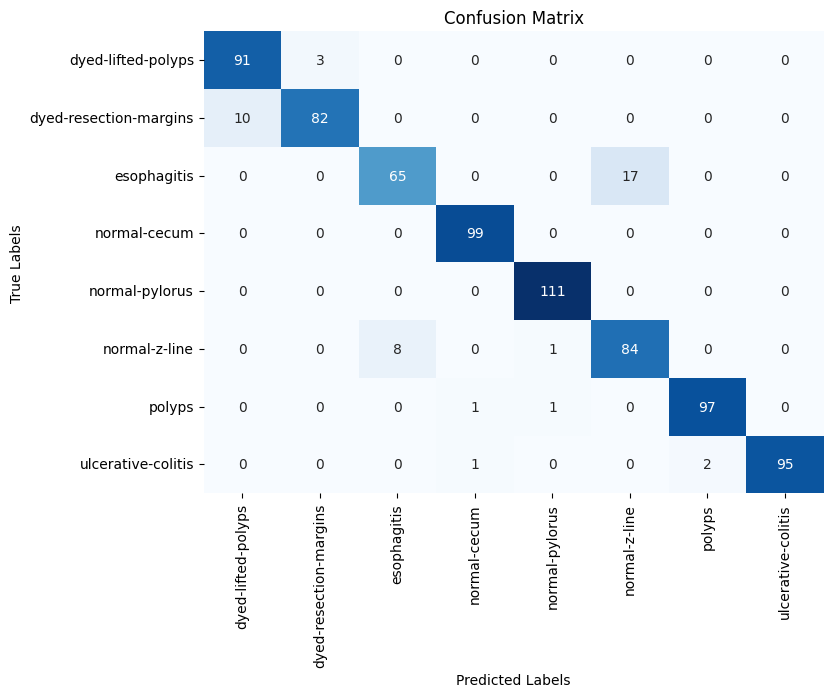

In [26]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()